In [1]:
from haloflow.config import get_dat_dir
from haloflow.npe.optuna_training import NPEOptunaTraining
from haloflow.mmd.models import MMDModel
import haloflow.data as D
import torch
import numpy as np


/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

In [3]:
obs = 'mags_morph_extra'

In [4]:
all_sims = ['TNG_ALL', 'Eagle100', 'Simba100']

dann_sim = 'TNG_ALL'

In [6]:
FP = get_dat_dir() + f'hf2/mmd/models/mmd_model_v2_to_{dann_sim}_{obs}.pt'

In [7]:
DAT_DIR = get_dat_dir()
ALL_SIMS = ["TNG_ALL", "Eagle100", "Simba100"]


def get_mmd_preds_inital(fp, obs, sim):
    y_test, x_test = D.hf2_centrals('all', obs, sim=sim, version=1)

    if sim not in ALL_SIMS:
        raise ValueError(f"Simulation {sim} not recognized. Choose from {ALL_SIMS}.")

    # Load global mean and std normalization parameters
    global_stats = np.load(DAT_DIR + 'hf2/mmd/models/global_mean_std.npz', allow_pickle=True)
    g_mean = global_stats['mean']
    g_std = global_stats['std']

    x_test = (x_test - g_mean) / g_std
    
    all_X = torch.tensor(x_test, dtype=torch.float32)
    input_dim = all_X.shape[1]

    
    model = MMDModel(input_dim, output_dim=2)
    
    with torch.no_grad():
        features, label_pred = model(all_X)
    
    features = features.detach().numpy()
    label_pred = label_pred.detach().numpy()
    
    return features, label_pred

source_features = np.array([])
labels_source = np.array([])

for i, sim in enumerate(all_sims):
    if sim == dann_sim:
        continue
    
    s_f, _ = get_mmd_preds_inital(FP, obs, sim)
    source_features = np.vstack([source_features, s_f]) if source_features.size else s_f

    labels = np.array([i] * len(s_f))
    labels_source = np.hstack([labels_source, labels])

In [8]:
source_features.shape, labels_source.shape

((17719, 32), (17719,))

In [18]:
def get_mmd_preds(fp, obs, sim):
    y_test, x_test = D.hf2_centrals('train', obs, sim=sim, version=1)

    if sim not in ALL_SIMS:
        raise ValueError(f"Simulation {sim} not recognized. Choose from {ALL_SIMS}.")

    # Load global mean and std normalization parameters
    global_stats = np.load(DAT_DIR + 'hf2/mmd/models/global_mean_std.npz', allow_pickle=True)
    g_mean = global_stats['mean']
    g_std = global_stats['std']

    x_test = (x_test - g_mean) / g_std
    
    all_X = torch.tensor(x_test, dtype=torch.float32)
    input_dim = all_X.shape[1]

    
    model = MMDModel(input_dim, output_dim=2)
    model.load_state_dict(torch.load(fp))
    
    model.eval()
    
    with torch.no_grad():
        features, label_pred = model(all_X)
    
    features = features.detach().numpy()
    label_pred = label_pred.detach().numpy()
    
    return features, label_pred
    

source_features_final = np.array([])
labels_source_final = np.array([])

for i, sim in enumerate(all_sims):
    if sim == dann_sim:
        continue
    
    s_f, _ = get_mmd_preds(FP, obs, sim)
    source_features_final = np.vstack([source_features_final, s_f]) if source_features_final.size else s_f

    labels = np.array([i] * len(s_f))
    labels_source_final = np.hstack([labels_source_final, labels])

In [19]:
source_features_final.shape, labels_source_final.shape

((15946, 32), (15946,))

In [20]:
target_features = np.array([])
labels_target = np.array([])
target_features_final = np.array([])

t_f, _ = get_mmd_preds_inital(FP, obs, dann_sim)
target_features = np.vstack([target_features, t_f]) if target_features.size else t_f
labels = np.array([2] * len(t_f))


t_f_final , _ = get_mmd_preds(FP, obs, dann_sim)
target_features_final = np.vstack([target_features_final, t_f_final]) if target_features_final.size else t_f_final
labels_final = np.array([2] * len(t_f_final))
labels_target = np.hstack([labels_target, labels])

In [21]:
target_features.shape, labels_target.shape, target_features_final.shape, labels_final.shape

((17201, 32), (17201,), (15480, 32), (15480,))

In [22]:
# Now do t-SNE
import umap
import matplotlib.pyplot as plt

In [23]:
umap_model = umap.UMAP(n_neighbors=15,
                        n_components=2,
                        metric='euclidean',
                        min_dist=0.1,
                        random_state=42)

# initial run
source_tsne = umap_model.fit_transform(source_features)
target_tsne = umap_model.fit_transform(target_features)

/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


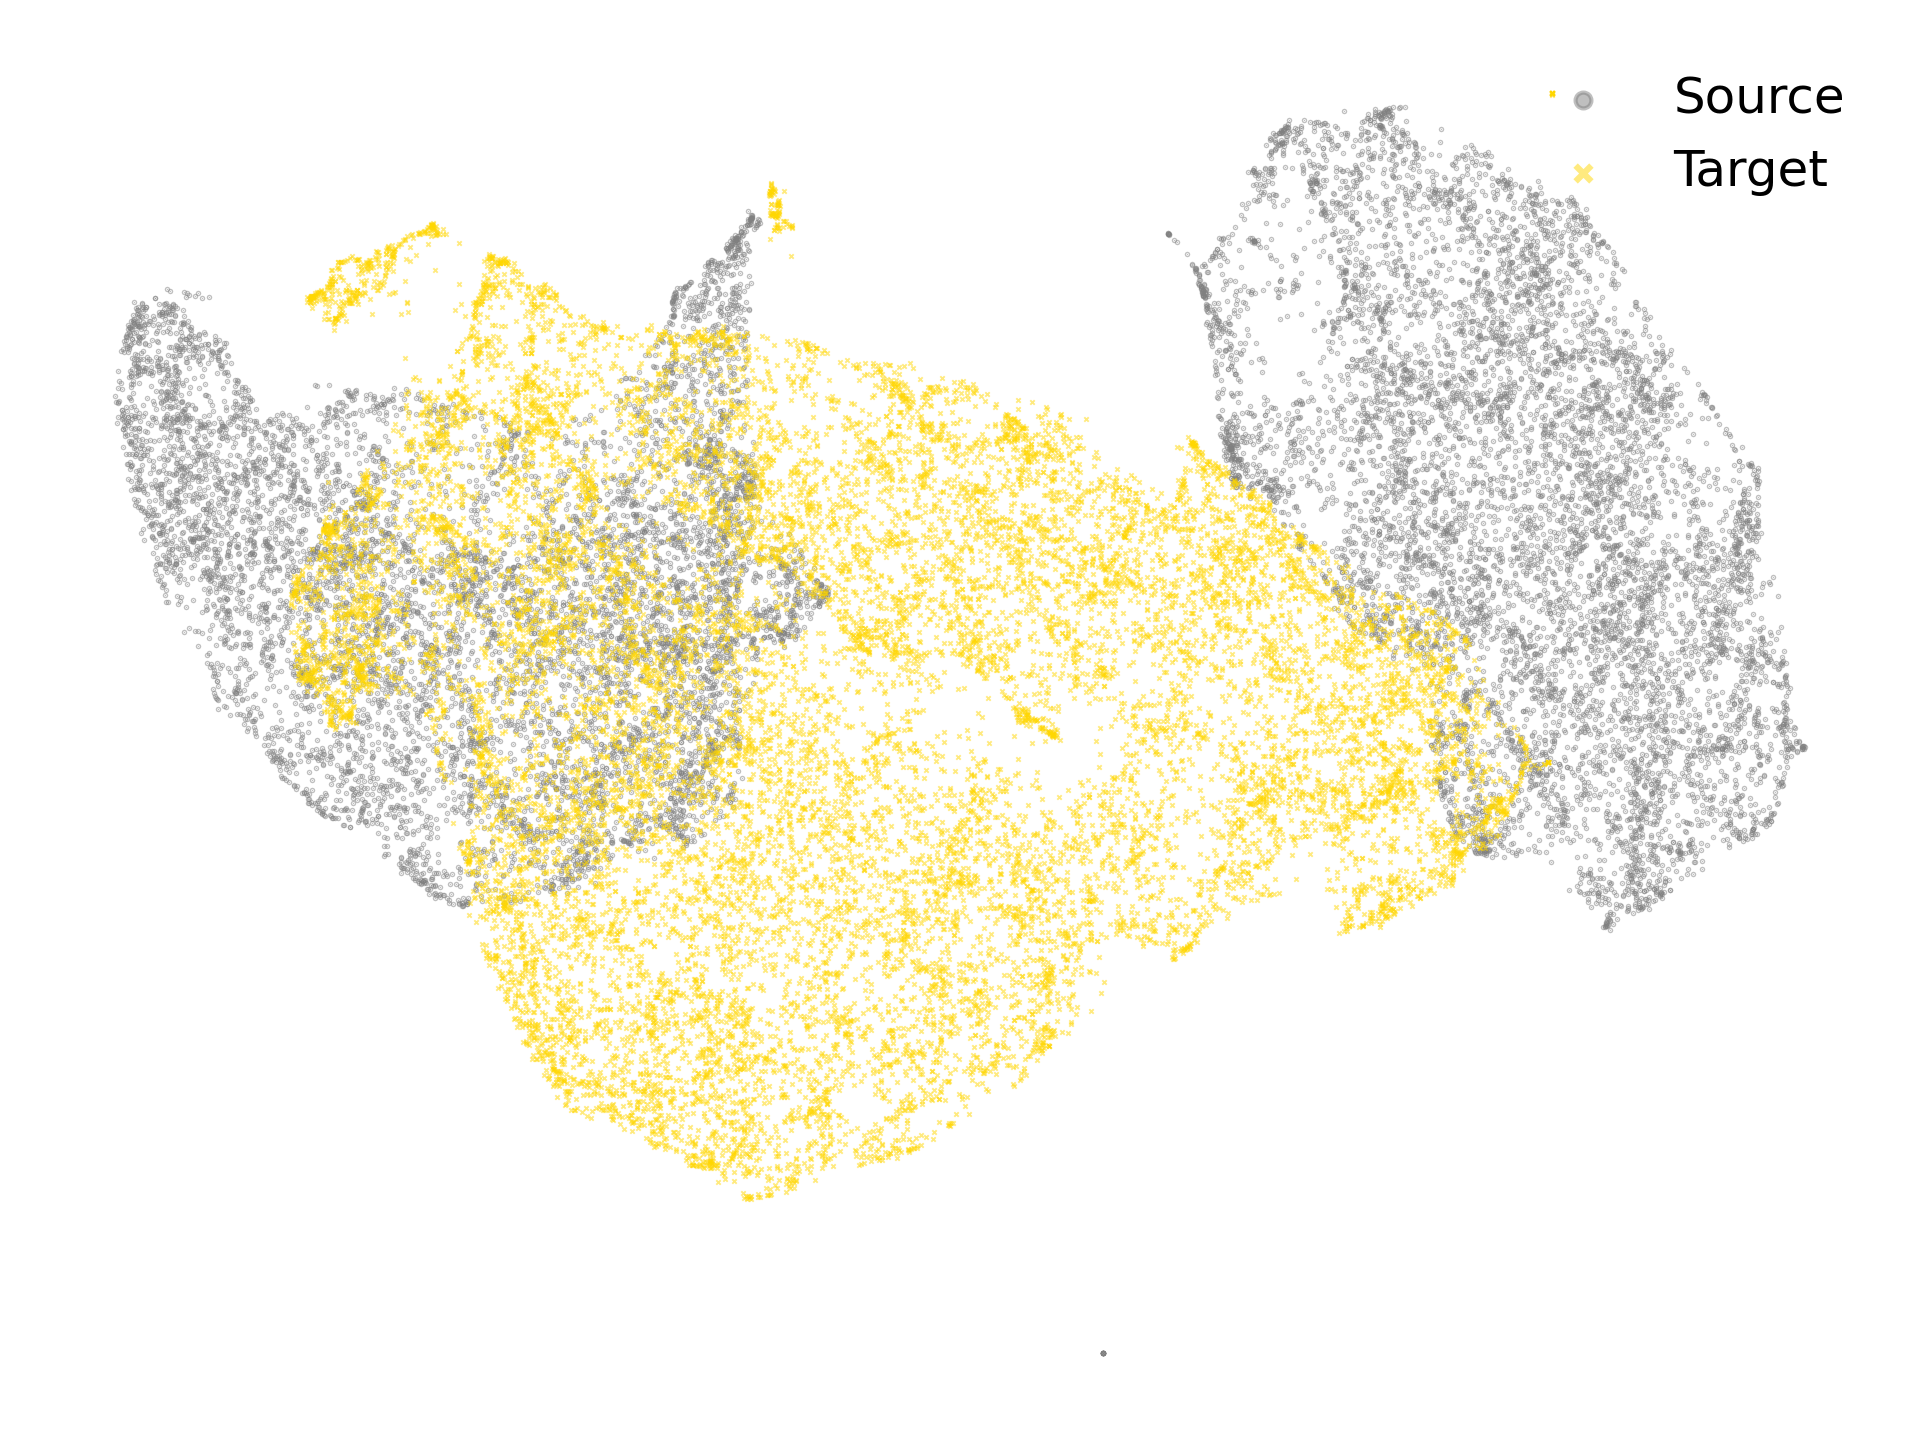

In [25]:
# plot
plt.figure(figsize=(8,6), dpi=300)
plt.scatter(source_tsne[:,0], source_tsne[:,1], color='gray', alpha=0.5, label='Source', s=0.1)
plt.scatter(target_tsne[:,0], target_tsne[:,1], marker='x', color='gold', label='Target', s=0.1, alpha=0.5)

# no ticks and spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

# add text on top left


# add legend with scatter size 12 for the markers
plt.legend(markerscale=12, fontsize=12, frameon=False, loc='upper right')

In [43]:
umap_model_final = umap.UMAP(n_neighbors=15,
                        n_components=2,
                        metric='euclidean',
                        min_dist=0.1,
                        random_state=42)

# initial run
umap_model_final.fit(source_features_final)

source_tsne = umap_model_final.transform(source_features_final)
target_tsne = umap_model_final.transform(target_features_final)

/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


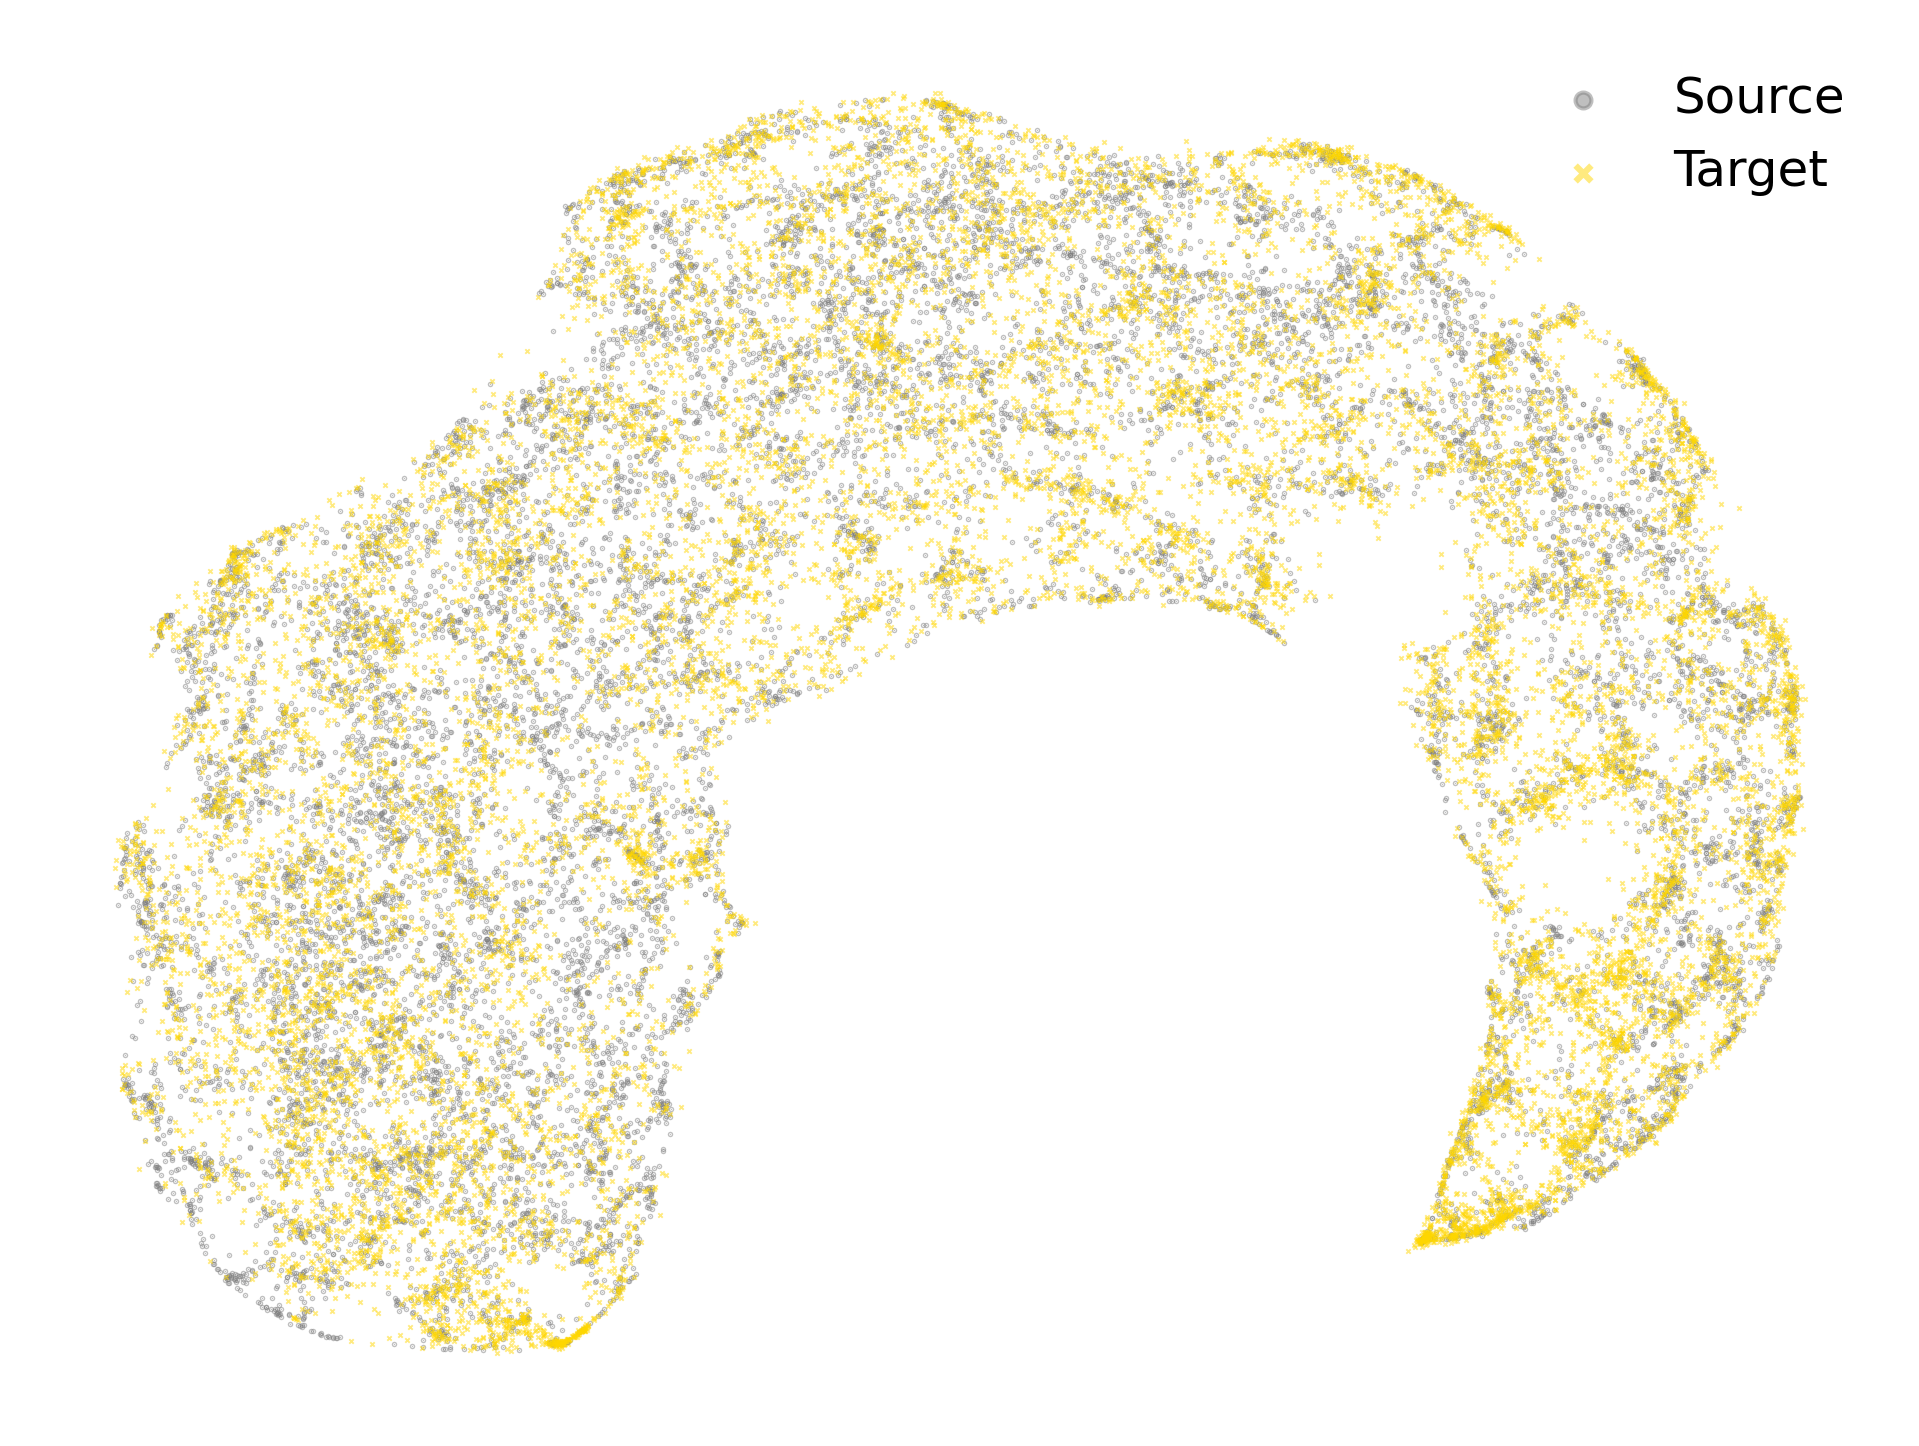

In [44]:
# plot
plt.figure(figsize=(8,6), dpi=300)
plt.scatter(source_tsne[:,0], source_tsne[:,1], color='gray', alpha=0.5, label='Source', s=0.1)
plt.scatter(target_tsne[:,0], target_tsne[:,1], marker='x', color='gold', label='Target', s=0.1, alpha=0.5)

# no ticks and spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

# add text on top left
# plt.text(-4, 17, 'After DA', fontsize=16, weight='bold')

# add legend with scatter size 12 for the markers
plt.legend(markerscale=12, fontsize=12, frameon=False)